In [2]:
import tarfile
import os

# Path to the tgz file
TGZ_PATH = "/kaggle/input/flower/102flowers.tgz"
EXTRACT_PATH = "/kaggle/working/flowers_jpg"

os.makedirs(EXTRACT_PATH, exist_ok=True)

# Extract tgz
with tarfile.open(TGZ_PATH, 'r:gz') as tar:
    tar.extractall(path=EXTRACT_PATH)

print("✅ Extraction complete. Images saved to:", EXTRACT_PATH)


✅ Extraction complete. Images saved to: /kaggle/working/flowers_jpg


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

INPUT_DIR = os.path.join(EXTRACT_PATH, "jpg")  
OUTPUT_DIR = "/kaggle/working/flowers_preprocessed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224   # standard size for CNNs

def preprocess_and_save(img_path, save_path, size=IMG_SIZE):
    img = cv2.imread(img_path)
    if img is None:
        return False
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Remove very small/invalid images
    if img.shape[0] < 50 or img.shape[1] < 50:
        return False
    
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    
    np.save(save_path, img)
    return True

valid, invalid = 0, 0
for fname in tqdm(os.listdir(INPUT_DIR)):
    in_path = os.path.join(INPUT_DIR, fname)
    out_path = os.path.join(OUTPUT_DIR, fname.split('.')[0])
    if preprocess_and_save(in_path, out_path):
        valid += 1
    else:
        invalid += 1

print(f"✅ Preprocessing finished. Valid: {valid}, Removed: {invalid}")


100%|██████████| 8189/8189 [00:29<00:00, 280.26it/s]

✅ Preprocessing finished. Valid: 8189, Removed: 0


In [4]:
import os


print("Files saved in:", OUTPUT_DIR)
print("Sample files:", os.listdir(OUTPUT_DIR)[:10])


first_file = os.path.join(OUTPUT_DIR, os.listdir(OUTPUT_DIR)[0])
print("First saved file path:", first_file)


Files saved in: /kaggle/working/flowers_preprocessed
Sample files: ['image_02755.npy', 'image_07095.npy', 'image_04722.npy', 'image_01420.npy', 'image_05172.npy', 'image_06769.npy', 'image_06628.npy', 'image_04809.npy', 'image_03260.npy', 'image_05097.npy']
First saved file path: /kaggle/working/flowers_preprocessed/image_02755.npy


# Exploring the dataset

✅ Total preprocessed images: 8189
Sample shape: (224, 224, 3)
Data type: float32
Pixel range: 0.0 to 1.0


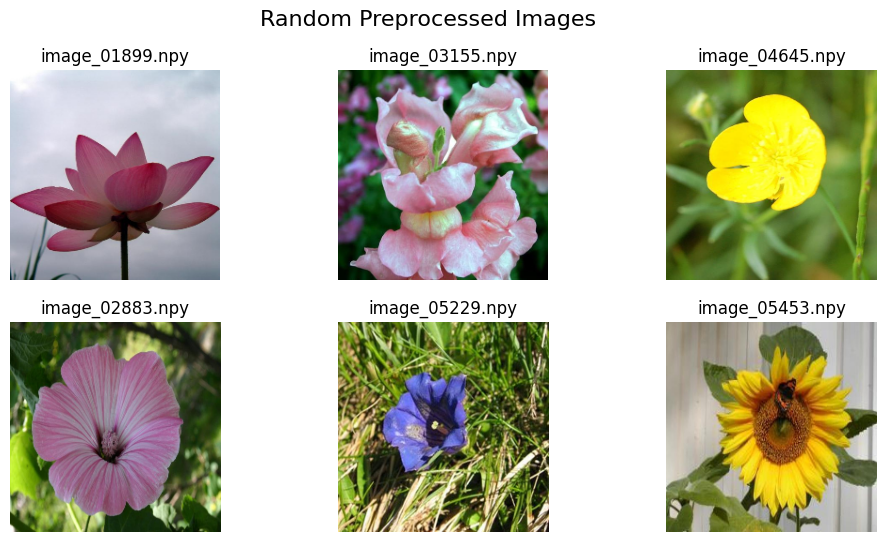

Dataset mean pixel value: 0.35399875
Dataset min pixel value: 0.0
Dataset max pixel value: 1.0


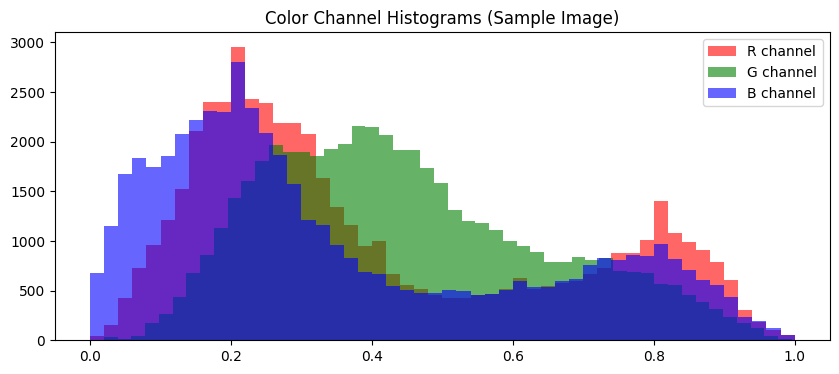

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Path where npy files are saved
DATA_DIR = "/kaggle/working/flowers_preprocessed"

# 1. Count total images
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".npy")]
print(f"✅ Total preprocessed images: {len(files)}")

# 2. Load one image to check shape & dtype
sample = np.load(os.path.join(DATA_DIR, files[0]))
print("Sample shape:", sample.shape)
print("Data type:", sample.dtype)
print("Pixel range:", sample.min(), "to", sample.max())

# 3. Visualize few random images
plt.figure(figsize=(12, 6))
for i in range(6):
    f = random.choice(files)
    img = np.load(os.path.join(DATA_DIR, f))
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f)
    plt.axis("off")
plt.suptitle("Random Preprocessed Images", fontsize=16)
plt.show()

# 4. Compute dataset-wide statistics
means, mins, maxs = [], [], []
for f in random.sample(files, min(200, len(files))):  # sample for speed
    img = np.load(os.path.join(DATA_DIR, f))
    means.append(img.mean())
    mins.append(img.min())
    maxs.append(img.max())

print("Dataset mean pixel value:", np.mean(means))
print("Dataset min pixel value:", np.min(mins))
print("Dataset max pixel value:", np.max(maxs))

# 5. Plot histograms for one random image (R, G, B channels)
img = np.load(os.path.join(DATA_DIR, random.choice(files)))
colors = ("r", "g", "b")
plt.figure(figsize=(10, 4))
for i, col in enumerate(colors):
    plt.hist(img[:, :, i].ravel(), bins=50, color=col, alpha=0.6, label=f"{col.upper()} channel")
plt.legend()
plt.title("Color Channel Histograms (Sample Image)")
plt.show()


# Color Feature Extraction

In [6]:
def extract_histogram(img, color_space='RGB', bins=(8, 8, 8)):
    """
    Extract histogram in RGB, HSV, or Lab color space.
    """
    if color_space == 'HSV':
        img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    elif color_space == 'Lab':
        img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2Lab)

    hist = cv2.calcHist([img], [0,1,2], None, bins, [0,256,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [7]:
from scipy.stats import skew

def extract_color_moments(img):
    """
    Compute mean, std, skewness for each channel.
    Works for any 3-channel color space.
    """
    features = []
    for i in range(3):
        channel = img[:,:,i].ravel()
        features.append(np.mean(channel))
        features.append(np.std(channel))
        features.append(skew(channel))
    return np.array(features)


In [8]:
DATA_DIR = "/kaggle/working/flowers_preprocessed"
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".npy")]

all_features = []

for f in files:
    img = np.load(os.path.join(DATA_DIR, f))  # already normalized
    
    # RGB Histogram + Moments
    rgb_hist = extract_histogram(img, "RGB")
    rgb_moments = extract_color_moments((img*255).astype(np.uint8))

    # HSV Histogram + Moments
    hsv_hist = extract_histogram(img, "HSV")
    hsv_img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    hsv_moments = extract_color_moments(hsv_img)

    # Lab Histogram + Moments
    lab_hist = extract_histogram(img, "Lab")
    lab_img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2Lab)
    lab_moments = extract_color_moments(lab_img)

    # Combine everything → Hybrid Color Feature Vector
    feature_vector = np.concatenate([
        rgb_hist, rgb_moments,
        hsv_hist, hsv_moments,
        lab_hist, lab_moments
    ])
    
    all_features.append(feature_vector)

all_features = np.array(all_features)
print("✅ Color feature extraction done.")
print("Hybrid feature shape:", all_features.shape)

# Save
np.save("/kaggle/working/color_hybrid_features.npy", all_features)
print("Saved at /kaggle/working/color_hybrid_features.npy")


✅ Color feature extraction done.
Hybrid feature shape: (8189, 1563)
Saved at /kaggle/working/color_hybrid_features.npy


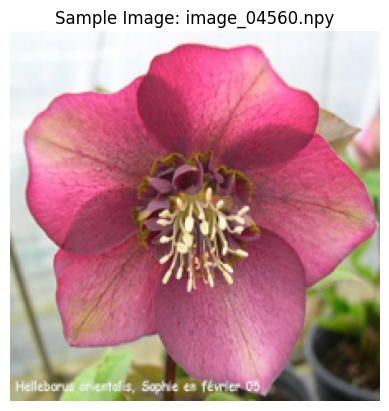

In [9]:
import random

# Load one random image
sample_file = random.choice(files)
sample_img = np.load(os.path.join(DATA_DIR, sample_file))

plt.imshow(sample_img)
plt.title(f"Sample Image: {sample_file}")
plt.axis("off")
plt.show()

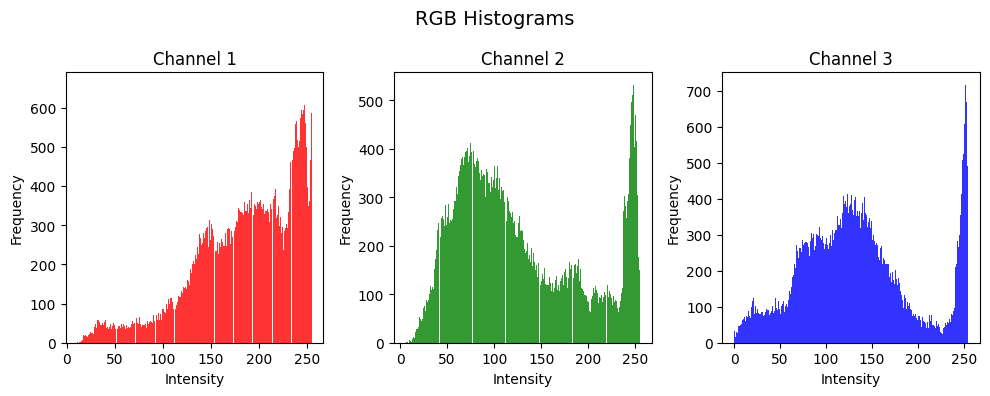

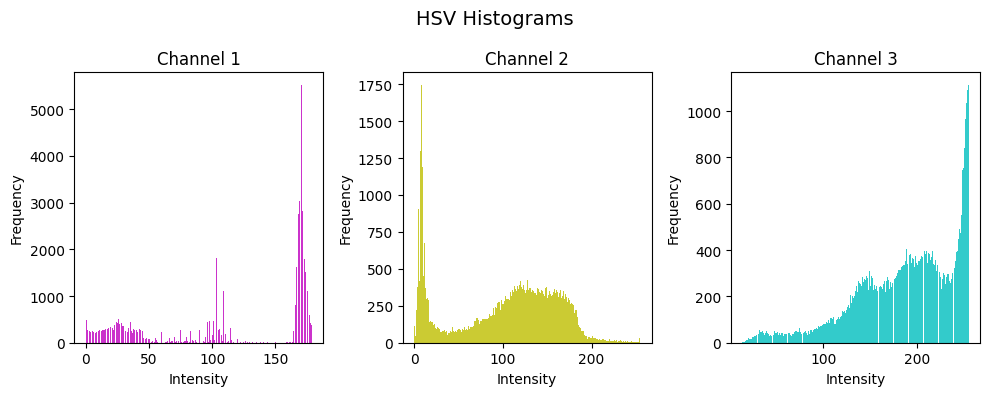

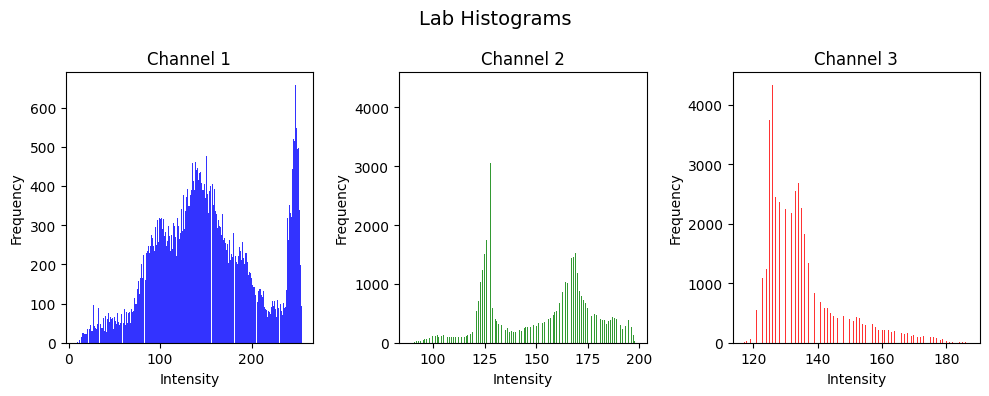

In [10]:
def plot_color_histograms(img):
    img_uint8 = (img*255).astype(np.uint8)

    # Convert
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2Lab)

    color_spaces = {
        "RGB": img_uint8,
        "HSV": hsv,
        "Lab": lab
    }
    colors = {
        "RGB": ["r", "g", "b"],
        "HSV": ["m", "y", "c"],
        "Lab": ["b", "g", "r"]
    }

    for space, image in color_spaces.items():
        plt.figure(figsize=(10,4))
        plt.suptitle(f"{space} Histograms", fontsize=14)

        for i, col in enumerate(colors[space]):
            plt.subplot(1,3,i+1)
            plt.hist(image[:,:,i].ravel(), bins=256, color=col, alpha=0.8)
            plt.title(f"Channel {i+1}")
            plt.xlabel("Intensity")
            plt.ylabel("Frequency")
        
        plt.tight_layout()
        plt.show()

# Run visualization
plot_color_histograms(sample_img)

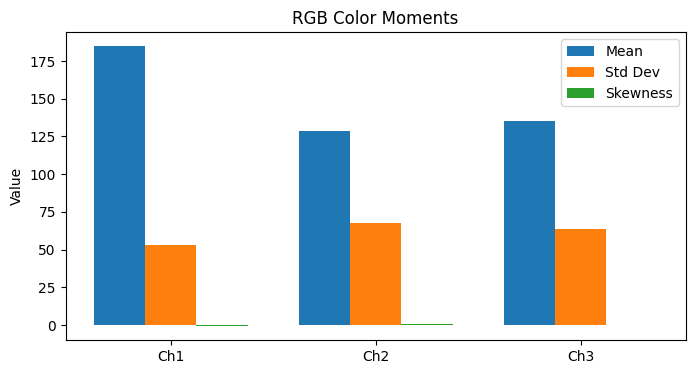

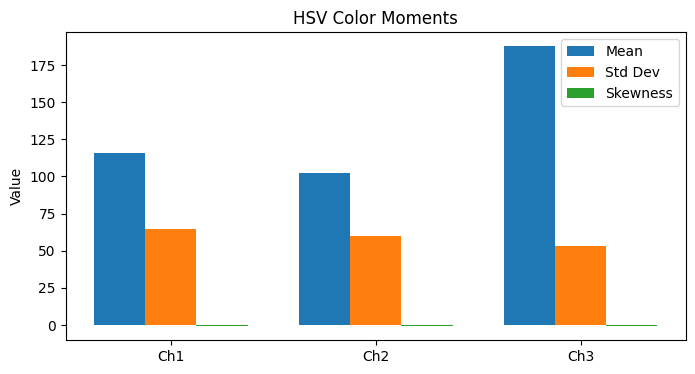

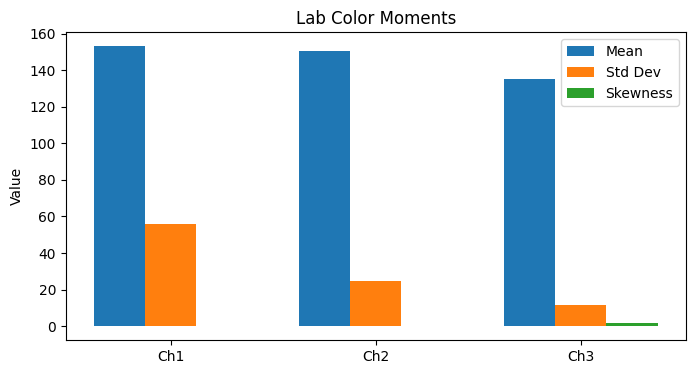

In [11]:
from scipy.stats import skew

def plot_color_moments(img):
    img_uint8 = (img*255).astype(np.uint8)

    # Convert to color spaces
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2Lab)

    color_spaces = {
        "RGB": img_uint8,
        "HSV": hsv,
        "Lab": lab
    }

    for space, image in color_spaces.items():
        means, stds, skews = [], [], []

        for i in range(3):  # 3 channels
            channel = image[:,:,i].ravel()
            means.append(np.mean(channel))
            stds.append(np.std(channel))
            skews.append(skew(channel))

        # Plot moments
        x = np.arange(3)
        width = 0.25

        plt.figure(figsize=(8,4))
        plt.bar(x - width, means, width, label="Mean")
        plt.bar(x, stds, width, label="Std Dev")
        plt.bar(x + width, skews, width, label="Skewness")

        plt.xticks(x, [f"Ch{i+1}" for i in range(3)])
        plt.ylabel("Value")
        plt.title(f"{space} Color Moments")
        plt.legend()
        plt.show()

# Run on sample image
plot_color_moments(sample_img)


# Text Feature Extraction

In [12]:
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops


def extract_glcm_features(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Extract GLCM features: contrast, correlation, energy, homogeneity.
    img: grayscale image
    """
    # Convert to grayscale
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Compute GLCM
    glcm = graycomatrix(gray, 
                        distances=distances, 
                        angles=angles, 
                        symmetric=True, 
                        normed=True)
    
    # Extract texture features
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    
    return np.array([contrast, correlation, energy, homogeneity])


In [13]:
# Load one sample image
sample_path = "/kaggle/working/flowers_preprocessed/image_00547.npy"
img = np.load(sample_path)

# Extract GLCM features
glcm_features = extract_glcm_features(img)
print("GLCM Features:", glcm_features)

GLCM Features: [2.42723328e+02 9.81968241e-01 3.03932942e-02 2.57380301e-01]


In [14]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(img, P=8, R=1):
    """
    Extract Local Binary Pattern (LBP) histogram features.
    P = number of circular neighbors
    R = radius of circle
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Compute LBP
    lbp = local_binary_pattern(gray, P, R, method="uniform")

    # Histogram of LBP values
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    return hist


In [15]:
import matplotlib.pyplot as plt

def show_lbp_visualization(img, P=8, R=1):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")

    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(gray, cmap="gray")
    plt.title("Original Grayscale")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP Image")
    plt.axis("off")
    
    plt.show()


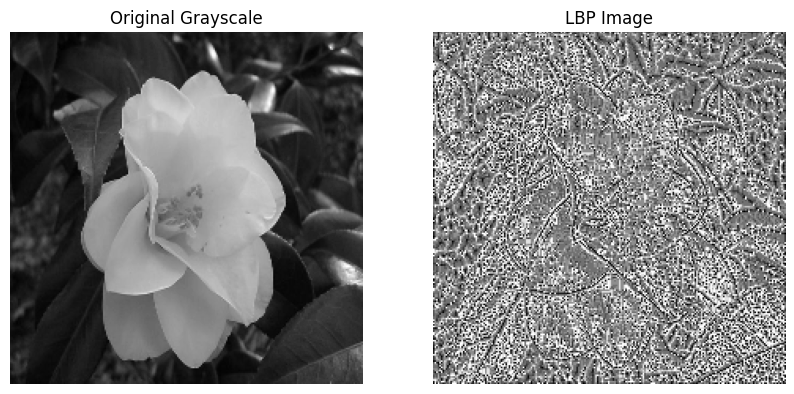

In [16]:
img = np.load("/kaggle/working/flowers_preprocessed/image_07614.npy")
show_lbp_visualization(img)


In [17]:
import pywt

def extract_wavelet_features(img, wavelet="db1", level=2):
    """
    Extract wavelet texture features from an image.
    - Uses Discrete Wavelet Transform (DWT).
    - Collects mean and std of coefficients from each channel.
    """
    features = []

    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Perform DWT
    coeffs = pywt.wavedec2(gray, wavelet=wavelet, level=level)

    for coeff in coeffs:
        if isinstance(coeff, tuple):  # detail coefficients (LH, HL, HH)
            for c in coeff:
                features.append(np.mean(c))
                features.append(np.std(c))
        else:  # approximation coefficients
            features.append(np.mean(coeff))
            features.append(np.std(coeff))

    return np.array(features)


In [18]:
img = np.load("/kaggle/working/flowers_preprocessed/image_07614.npy")
wavelet_feats = extract_wavelet_features(img)
print("Wavelet feature vector length:", len(wavelet_feats))

Wavelet feature vector length: 14


In [19]:
def extract_gabor_features(img, ksize=31, sigma=4.0, lambd=10.0, gamma=0.5, num_orientations=8):
    """
    Extract Gabor texture features from an image.
    - Applies Gabor filters at multiple orientations.
    - Returns mean & std of filtered responses.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    features = []

    for theta in np.linspace(0, np.pi, num_orientations, endpoint=False):
        # Create Gabor kernel
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)

        # Filter the image
        fimg = cv2.filter2D(gray, cv2.CV_8UC3, kernel)

        # Collect statistical features
        features.append(np.mean(fimg))
        features.append(np.std(fimg))

    return np.array(features)


In [20]:
img = np.load("/kaggle/working/flowers_preprocessed/image_07614.npy")
gabor_feats = extract_gabor_features(img)
print("Gabor feature vector length:", len(gabor_feats))


Gabor feature vector length: 16


# Shape Feature Extraction

In [21]:
def extract_edges(img):
    """
    Extract edges using Canny and Sobel operators.
    Returns edge histograms as features.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Canny edges
    canny_edges = cv2.Canny(gray, 100, 200)

    # Sobel edges (x and y)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = cv2.magnitude(sobelx, sobely)

    # Histograms as features
    canny_hist = np.histogram(canny_edges.ravel(), bins=16, range=(0, 256))[0]
    sobel_hist = np.histogram(sobel_edges.ravel(), bins=16, range=(0, 256))[0]

    return np.concatenate([canny_hist, sobel_hist])


In [22]:
edge_feats = extract_edges(img)
print("Edge Features:", edge_feats.shape)


Edge Features: (32,)


In [23]:
def extract_contours(img):
    """
    Extract contour-based features: number of contours,
    average area, and average perimeter.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Binary mask for contours
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.array([0, 0, 0])  # No contours found

    areas = [cv2.contourArea(c) for c in contours]
    perimeters = [cv2.arcLength(c, True) for c in contours]

    num_contours = len(contours)
    avg_area = np.mean(areas)
    avg_perimeter = np.mean(perimeters)

    return np.array([num_contours, avg_area, avg_perimeter])


In [24]:
contour_feats = extract_contours(img)
print("Contour Features:", contour_feats)


Contour Features: [ 20.         888.375       58.52655426]


In [25]:
from skimage.feature import hog

def extract_hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extract HOG (Histogram of Oriented Gradients) features.
    """
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    hog_features, hog_image = hog(
        gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=True
    )
    
    return hog_features, hog_image


HOG feature vector length: 26244


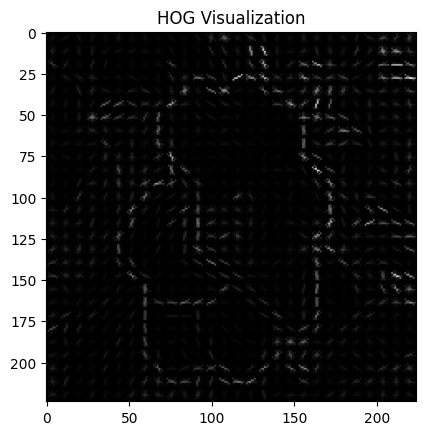

In [26]:
hog_features, hog_vis = extract_hog(img)
print("HOG feature vector length:", len(hog_features))

# Show visualization
plt.imshow(hog_vis, cmap="gray")
plt.title("HOG Visualization")
plt.show()


# Hybrid feature vector fusion 

In [27]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

# ---------- Feature Extractors ----------

def extract_color_histogram(img, bins=(8, 8, 8)):
    hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0,256, 0,256, 0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_color_moments(img):
    moments = []
    for i in range(3):  # channels
        channel = img[:, :, i]
        mean = np.mean(channel)
        std = np.std(channel)
        skew = np.mean((channel - mean) ** 3)
        moments.extend([mean, std, skew])
    return np.array(moments)

def extract_glcm_features(img):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True)
    feats = []
    for prop in ('contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'):
        feats.append(graycoprops(glcm, prop).flatten())
    return np.hstack(feats)

def extract_lbp(img, P=8, R=1):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, P + 3),
                           range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_hog(img):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True, feature_vector=True)
    return features

# ---------- Hybrid Extractor ----------
def extract_hybrid_features(img):
    f1 = extract_color_histogram((img*255).astype(np.uint8))
    f2 = extract_color_moments((img*255).astype(np.uint8))
    f3 = extract_glcm_features(img)
    f4 = extract_lbp(img)
    f5 = extract_hog(img)
    return np.hstack([f1, f2, f3, f4, f5])

# ---------- Dataset Builder ----------
def build_feature_dataset(preprocessed_dir):
    features = []
    ids = []
    for fname in os.listdir(preprocessed_dir):
        if fname.endswith(".npy"):
            img = np.load(os.path.join(preprocessed_dir, fname))
            feats = extract_hybrid_features(img)
            features.append(feats)
            ids.append(fname)
    return pd.DataFrame(features, index=ids)

# ---------- Run ----------
df = build_feature_dataset("/kaggle/working/flowers_preprocessed/")
print("✅ Hybrid feature dataset shape:", df.shape)


✅ Hybrid feature dataset shape: (8189, 26799)


In [28]:
import numpy as np

data = np.load("/kaggle/working/color_hybrid_features.npy", allow_pickle=True)
print(type(data))
print(data.shape)
print(data[:2])   # show first 2 rows


<class 'numpy.ndarray'>
(8189, 1563)
[[  1.           0.           0.         ... 134.98379703  14.92619213
    1.97138412]
 [  1.           0.           0.         ... 146.43399235  14.40666667
   -0.78638829]]


In [29]:
import numpy as np
import pandas as pd

# Load hybrid features
data = np.load("/kaggle/working/color_hybrid_features.npy", allow_pickle=True)

# Split features and labels
features = data[:, :-1]   # all columns except last
labels = data[:, -1]      # last column is label

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df["label"] = labels

# Save to CSV
features_df.to_csv("/kaggle/working/hybrid_features.csv", index=False)

print("✅ Hybrid features with labels saved to /kaggle/working/hybrid_features.csv")


✅ Hybrid features with labels saved to /kaggle/working/hybrid_features.csv


# Particle Swarm Optimization

In [32]:
data = np.load("/kaggle/working/color_hybrid_features.npy", allow_pickle=True)
print(type(data))
print(data.shape)


<class 'numpy.ndarray'>
(8189, 1563)


In [35]:
import scipy.io
import numpy as np

# Load labels
labels_mat = scipy.io.loadmat("/kaggle/input/matfiles/imagelabels.mat")
y = labels_mat["labels"].flatten() - 1   # Convert from 1–102 → 0–101

print("y shape:", y.shape)
print("Unique classes:", np.unique(y))
print("Number of samples:", len(y))

y shape: (8189,)
Unique classes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101]
Number of samples: 8189


In [36]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import scipy.io


X = np.load("color_hybrid_features.npy")   # shape (8189, 1563)

labels_mat = scipy.io.loadmat("/kaggle/input/matfiles/imagelabels.mat")
y = labels_mat["labels"].flatten() - 1     # shape (8189,)

print("X shape:", X.shape)
print("y shape:", y.shape, "Unique classes:", len(np.unique(y)))


scaler = StandardScaler()
X = scaler.fit_transform(X)


def fitness(mask):
    selected = np.where(mask == 1)[0]
    if len(selected) == 0:
        return 0
    X_sel = X[:, selected]

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train, test in skf.split(X_sel, y):
        clf = LogisticRegression(max_iter=2000, solver="lbfgs", multi_class="multinomial")
        clf.fit(X_sel[train], y[train])
        scores.append(clf.score(X_sel[test], y[test]))
    return np.mean(scores)


n_particles = 20
n_features = X.shape[1]
n_iterations = 30
w, c1, c2 = 0.7, 1.5, 1.5   # inertia, cognitive, social

rng = np.random.default_rng(42)

# Initialize swarm
pos = rng.integers(0, 2, size=(n_particles, n_features))  # binary masks
vel = rng.random((n_particles, n_features))               # velocities in [0,1]

pbest_pos = pos.copy()
pbest_fit = np.array([fitness(ind) for ind in pos])

gbest_idx = np.argmax(pbest_fit)
gbest_pos = pbest_pos[gbest_idx].copy()
gbest_fit = pbest_fit[gbest_idx]

history = [gbest_fit]


for it in range(n_iterations):
    for i in range(n_particles):
        # Update velocity
        vel[i] = (w * vel[i] +
                  c1 * rng.random(n_features) * (pbest_pos[i] - pos[i]) +
                  c2 * rng.random(n_features) * (gbest_pos - pos[i]))

        # Sigmoid + binary update
        sigmoid = 1 / (1 + np.exp(-vel[i]))
        pos[i] = (rng.random(n_features) < sigmoid).astype(int)

        # Evaluate
        fit = fitness(pos[i])
        if fit > pbest_fit[i]:
            pbest_fit[i] = fit
            pbest_pos[i] = pos[i].copy()

            if fit > gbest_fit:
                gbest_fit = fit
                gbest_pos = pos[i].copy()

    history.append(gbest_fit)
    print(f"Iter {it+1}/{n_iterations} | Best fitness: {gbest_fit:.5f} | Features: {gbest_pos.sum()}")

print("\n✅ PSO finished")
print("Best fitness:", gbest_fit)
print("Selected features:", int(gbest_pos.sum()))


X shape: (8189, 1563)
y shape: (8189,) Unique classes: 102
Iter 1/30 | Best fitness: 0.01502 | Features: 894
Iter 2/30 | Best fitness: 0.01502 | Features: 894
Iter 3/30 | Best fitness: 0.01502 | Features: 828
Iter 4/30 | Best fitness: 0.01502 | Features: 788
Iter 5/30 | Best fitness: 0.01563 | Features: 792
Iter 6/30 | Best fitness: 0.01563 | Features: 792
Iter 7/30 | Best fitness: 0.01587 | Features: 796
Iter 8/30 | Best fitness: 0.01587 | Features: 796
Iter 9/30 | Best fitness: 0.01587 | Features: 796
Iter 10/30 | Best fitness: 0.01587 | Features: 796
Iter 11/30 | Best fitness: 0.01588 | Features: 755
Iter 12/30 | Best fitness: 0.01600 | Features: 750
Iter 13/30 | Best fitness: 0.01734 | Features: 775
Iter 14/30 | Best fitness: 0.01734 | Features: 775
Iter 15/30 | Best fitness: 0.01734 | Features: 775
Iter 16/30 | Best fitness: 0.01734 | Features: 775
Iter 17/30 | Best fitness: 0.01734 | Features: 775
Iter 18/30 | Best fitness: 0.01734 | Features: 775
Iter 19/30 | Best fitness: 0.017

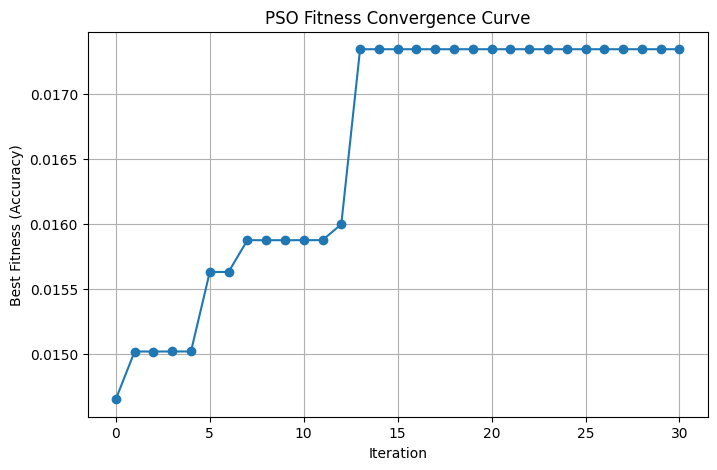

In [37]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.plot(range(len(history)), history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Fitness (Accuracy)")
plt.title("PSO Fitness Convergence Curve")
plt.grid(True)
plt.show()


# Cosine Similarity

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_images(query_idx, X_features, top_k=5):
    query = X_features[query_idx].reshape(1, -1)
    sims = cosine_similarity(query, X_features)[0]
    ranked_idx = sims.argsort()[::-1]  # descending order
    return ranked_idx[:top_k], sims[ranked_idx[:top_k]]


# Euclidean Distance (L2)

In [39]:
from sklearn.metrics.pairwise import euclidean_distances

def retrieve_images_euclidean(query_idx, X_features, top_k=5):
    query = X_features[query_idx].reshape(1, -1)
    dists = euclidean_distances(query, X_features)[0]
    ranked_idx = dists.argsort()  # ascending = closer
    return ranked_idx[:top_k], dists[ranked_idx[:top_k]]
